In [ ]:
import torch
import triton
import triton.language as tl
from copy import deepcopy

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


- 将up * silu(gate)进行优化，可以节约显存，不需要保存silu(gate)这个中间结果
- 主要3个版本，v1和v2类似，v1是行操作，v2是元素操作，性能差不过。这两个版本针对gate和up是单独计算的，都是连续的，提速大概2倍
- v3是up和gate是拼在一起的，不需要进行chunk，提速3-4倍

# v1

In [2]:
# 按行处理

@triton.jit
def _fused_silu_fwd(
        UP, GATE, Y,
        M, N,
        stride_m, stride_n,  #
        BLOCK_SIZE_N: tl.constexpr, #
        num_stages: tl.constexpr,
):

    pid = tl.program_id(axis=0)
    offset = pid * stride_m
    UP += offset
    GATE += offset
    Y += offset
    # cols = tl.arange(0, BLOCK_SIZE_N)
    # mask = cols < N
    # ptrs = offset + cols

    # up = tl.load(UP+ptrs, mask=mask, other=0.)
    # dtype = up.dtype
    # up = up.to(tl.float32)
    # gate = tl.load(GATE+ptrs, mask=mask, other=0.).to(tl.float32)
    # act = gate * tl.sigmoid(gate)
    # y = act * up
    # tl.store(Y+ptrs, y.to(dtype), mask=mask)
    cols = tl.arange(0, BLOCK_SIZE_N)
    for start_n in tl.range(0, N, BLOCK_SIZE_N):
        new_cols = cols + start_n
        mask = new_cols < N
        up = tl.load(UP+new_cols, mask=mask, other=0.)
        dtype = up.dtype
        up = up.to(tl.float32)
        gate = tl.load(GATE+new_cols, mask=mask, other=0.).to(tl.float32)
        act = gate * tl.sigmoid(gate)
        y = act * up
        tl.store(Y+new_cols, y.to(dtype), mask=mask)

@triton.jit
def _fused_silu_bwd_dupgate(UP, GATE, 
                               DY, DUP, DGATE,
                               stride_m, stride_n,
                               N, BLOCK_N: tl.constexpr,
                               num_stages: tl.constexpr):
    pid = tl.program_id(0)
    offset = pid * stride_m
    UP += offset
    GATE += offset
    DUP += offset
    DGATE += offset
    DY += offset
    # cols = tl.arange(0, BLOCK_N)
    # ptrs = offset + cols
    # mask = cols < N
    
    # dy = tl.load(DY+ptrs, mask=mask, other=0.)
    # dtype = dy.dtype
    # gate = tl.load(GATE+ptrs, mask=mask, other=0.).to(tl.float32)
    # up = tl.load(UP+ptrs, mask=mask, other=0.).to(tl.float32)

    # act = gate * tl.sigmoid(gate)
    # dup = act * dy
    # dact = up * dy
    # gate_neg_exp = tl.exp(-gate)
    # tmp = 1 + gate_neg_exp
    # fenzi =  tmp + gate * gate_neg_exp
    # fenmu = tmp * tmp
    # dgate = (fenzi / fenmu) * dact
    # tl.store(DUP+ptrs, dup.to(dtype), mask=mask)
    # tl.store(DGATE+ptrs, dgate.to(dtype), mask=mask)
    cols = tl.arange(0, BLOCK_N)
    for start_n in range(0, N, BLOCK_N):
        new_cols = cols + start_n
        mask = new_cols < N
        
        dy = tl.load(DY+new_cols, mask=mask, other=0.)
        dtype = dy.dtype
        gate = tl.load(GATE+new_cols, mask=mask, other=0.).to(tl.float32)
        up = tl.load(UP+new_cols, mask=mask, other=0.).to(tl.float32)
        gate_sigmoid = tl.sigmoid(gate)
        act = gate_sigmoid * gate
        dup = act * dy
        dact = up * dy
        dgate = (gate_sigmoid + act * (1-gate_sigmoid)) * dact
        tl.store(DUP+new_cols, dup.to(dtype), mask=mask)
        tl.store(DGATE+new_cols, dgate.to(dtype), mask=mask)

class _FusedSiLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, up, gate):
        up = up.view(-1, up.shape[-1])
        M, N = up.shape
        y = torch.empty_like(gate)
        BLOCK_SIZE_N = triton.next_power_of_2(N)
        BLOCK_SIZE_N = min(4096, BLOCK_SIZE_N)
        num_warps = 8
        num_stages = 4
        _fused_silu_fwd[(M,)](
            up, gate, y, 
            M, N,  #
            *up.stride(),  #
            BLOCK_SIZE_N,
            num_warps=num_warps, num_stages=num_stages, 
        )
        ctx.infos = (M, N, BLOCK_SIZE_N, *up.stride())
        ctx.save_for_backward(up, gate)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return y
    
    @staticmethod
    def backward(ctx, dy):
        # print(dy.stride())
        M, N, BLOCK_SIZE_N, stride_m, stride_n = ctx.infos
        # print(stride_m, stride_n)
        up, gate = ctx.saved_tensors

        dup = torch.empty_like(gate)
        dgate = torch.empty_like(gate)
        # BLOCK_SIZE_N = min(8192, BLOCK_SIZE_N)
        _fused_silu_bwd_dupgate[(M,)](up, gate,
                                   dy, dup, dgate,
                                   stride_m, stride_n,
                                   N, BLOCK_SIZE_N, 
                                   num_warps=ctx.num_warps, num_stages=ctx.num_stages)

        return dup, dgate


def up_gate_silu(up, gate):
    return up * torch.nn.functional.silu(gate)

fused_up_gate_silu = _FusedSiLU.apply

# v2

In [13]:
# 与unsloth中的类似，逐元素处理

@triton.jit
def _fused_silu_fwd_unsloth(
        UP, GATE, Y,
        N, BLOCK_SIZE: tl.constexpr, #
):

    pid = tl.program_id(axis=0)
    ptrs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = ptrs < N
    up = tl.load(UP+ptrs, mask=mask, other=0.)
    dtype = up.dtype
    up = up.to(tl.float32)
    gate = tl.load(GATE+ptrs, mask=mask, other=0.).to(tl.float32)
    act = gate * tl.sigmoid(gate)
    y = act * up
    tl.store(Y+ptrs, y.to(dtype), mask=mask)

@triton.jit
def _fused_silu_bwd_dupgate_unsloth(UP, GATE, 
                               DY, DUP, DGATE,
                               N, BLOCK_SIZE: tl.constexpr,):
    pid = tl.program_id(axis=0)
    ptrs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = ptrs < N
        
    dy = tl.load(DY+ptrs, mask=mask, other=0.)
    dtype = dy.dtype
    gate = tl.load(GATE+ptrs, mask=mask, other=0.).to(tl.float32)
    up = tl.load(UP+ptrs, mask=mask, other=0.).to(tl.float32)
    gate_sigmoid = tl.sigmoid(gate)
    act = gate_sigmoid * gate
    dup = act * dy
    dact = up * dy
    dgate = (gate_sigmoid + act * (1-gate_sigmoid)) * dact
    tl.store(DUP+ptrs, dup.to(dtype), mask=mask)
    tl.store(DGATE+ptrs, dgate.to(dtype), mask=mask)

class _FusedSiLU_Unsloth(torch.autograd.Function):
    @staticmethod
    def forward(ctx, up, gate):
        y = torch.empty_like(gate)
        BLOCK_SIZE = 2048
        N = up.nelement()
        # print(N)
        num_warps = 8
        num_stages = 4
        _fused_silu_fwd_unsloth[(triton.cdiv(N, BLOCK_SIZE),)](
            up, gate, y, 
            N, BLOCK_SIZE,
            num_warps=num_warps, num_stages=num_stages, 
        )
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.N = N
        ctx.save_for_backward(up, gate)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return y
    
    @staticmethod
    def backward(ctx, dy):
        up, gate = ctx.saved_tensors
        dup = torch.empty_like(gate)
        dgate = torch.empty_like(gate)
        _fused_silu_bwd_dupgate_unsloth[(triton.cdiv(ctx.N, ctx.BLOCK_SIZE),)](up, gate,
                                   dy, dup, dgate,
                                   ctx.N, ctx.BLOCK_SIZE, 
                                   num_warps=ctx.num_warps, num_stages=ctx.num_stages)

        return dup, dgate


def up_gate_silu(up, gate):
    return up * torch.nn.functional.silu(gate)

fused_up_gate_silu_unsloth = _FusedSiLU_Unsloth.apply

# 精度测试

In [59]:
dim = 18944
bs = 2
seq_len = 2048
dtype = torch.bfloat16
up1 = torch.randn(bs, 2048, dim).cuda().to(dtype)
gate1 = torch.randn(bs, 2048, dim).cuda().to(dtype)
up1.requires_grad_(True)
gate1.requires_grad_(True)
up2 = deepcopy(up1)
gate2 = deepcopy(gate1)
dy = torch.ones_like(up1)


In [60]:
if up1.grad is not None:
    up1.grad.zero_()
    up2.grad.zero_()
    gate1.grad.zero_()
    gate2.grad.zero_()

y1 = up_gate_silu(up1, gate1)
y1.backward(dy)

y2 = fused_up_gate_silu(up2, gate2)
y2.backward(dy)

atol = 1e-2
print(torch.allclose(y1, y2, atol=atol))
print(torch.allclose(up1.grad, up2.grad, atol=atol))
print(torch.allclose(gate1.grad, gate2.grad, atol=atol))

False
True
True


In [26]:
gate2.grad.stride()

(38797312, 18944, 1)

# forward

bs: 32, seq_len: 1024


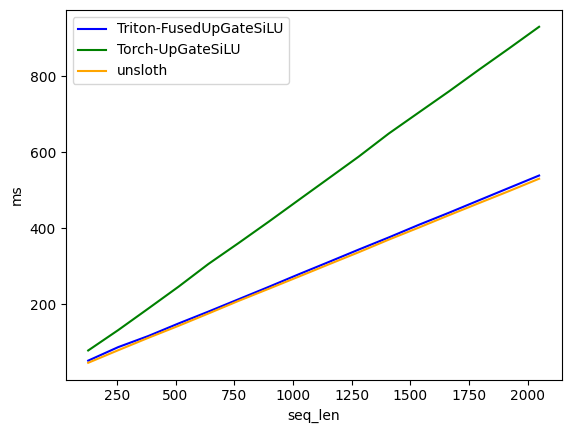

up gate silu forward:
    seq_len  Triton-FusedUpGateSiLU  Torch-UpGateSiLU     unsloth
0     128.0               51.311657         78.049086   45.650594
1     256.0               86.935535        131.831691   78.786485
2     384.0              116.132155        188.488439  111.367501
3     512.0              148.994893        245.735839  142.786458
4     640.0              180.455387        305.902451  175.458401
5     768.0              212.863773        360.769629  208.563909
6     896.0              245.325193        416.853368  240.290508
7    1024.0              278.548121        474.220604  272.357494
8    1152.0              310.949862        531.358242  304.737687
9    1280.0              343.738943        588.632345  336.770594
10   1408.0              375.725150        649.334967  369.974315
11   1536.0              408.962697        704.853952  401.741087
12   1664.0              440.709710        760.229766  434.225082
13   1792.0              473.501891        817.427993 

In [5]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU', 'unsloth'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",'unsloth'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 18944, 'bs': 4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    gate = torch.randn_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'Triton-FusedUpGateSiLU':
        ms = triton.testing.do_bench(lambda: fused_up_gate_silu(up, gate))

    if provider == 'Torch-UpGateSiLU':
        ms = triton.testing.do_bench(lambda: up_gate_silu(up, gate))

    if provider == 'unsloth':
        ms = triton.testing.do_bench(lambda: fused_up_gate_silu_unsloth(up, gate))

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


bs: 32, seq_len: 1024


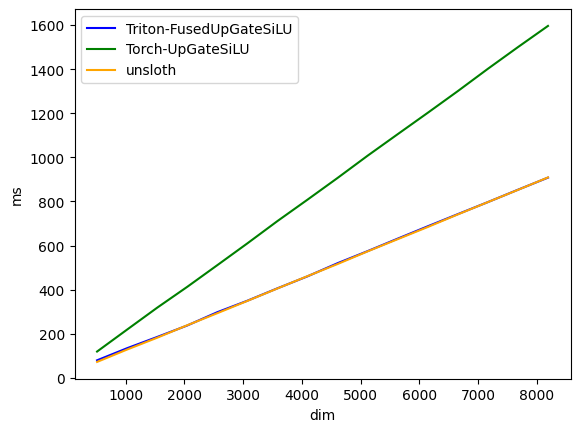

up gate silu forward:
       dim  Triton-FusedUpGateSiLU  Torch-UpGateSiLU     unsloth
0    512.0               79.367734        119.083442   72.031535
1   1024.0              134.312525        218.792737  128.255740
2   1536.0              185.179889        318.034142  181.858227
3   2048.0              237.317801        412.599087  238.348678
4   2560.0              297.579318        510.872424  293.006003
5   3072.0              349.587739        609.743774  348.785818
6   3584.0              405.867875        710.851848  405.184537
7   4096.0              460.165232        807.905436  461.037219
8   4608.0              519.782424        906.388879  516.030431
9   5120.0              574.536681       1007.358909  573.424697
10  5632.0              631.117165       1104.874849  628.713310
11  6144.0              687.125325       1201.895833  683.913708
12  6656.0              742.222309       1300.229073  740.971744
13  7168.0              796.840966       1401.401281  796.809316
14 

In [7]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU', 'unsloth'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",'unsloth'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 32}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    gate = torch.randn_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'Triton-FusedUpGateSiLU':
        ms = triton.testing.do_bench(lambda: fused_up_gate_silu(up, gate))
    if provider == 'Torch-UpGateSiLU':
        ms = triton.testing.do_bench(lambda: up_gate_silu(up, gate))
    if provider == 'unsloth':
        ms = triton.testing.do_bench(lambda: fused_up_gate_silu_unsloth(up, gate))

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# backward

bs: 32, seq_len: 1024


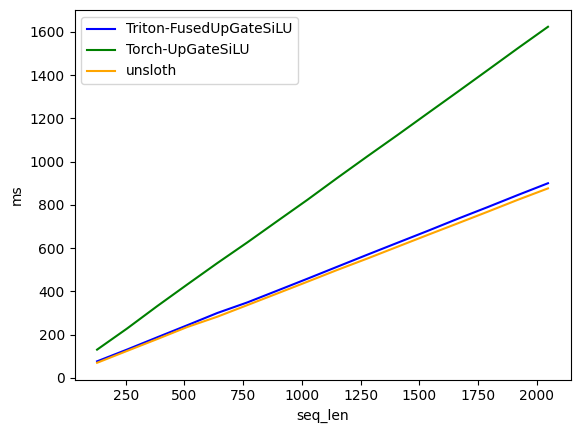

up gate silu forward:
    seq_len  Triton-FusedUpGateSiLU  Torch-UpGateSiLU     unsloth
0     128.0               76.059155        130.185530   69.415890
1     256.0              130.643770        228.088483  124.388605
2     384.0              187.084526        331.381053  179.063708
3     512.0              242.970541        431.499779  234.784678
4     640.0              299.690545        530.416012  282.459408
5     768.0              348.639309        626.253068  336.179078
6     896.0              403.322309        725.149393  390.221596
7    1024.0              458.295286        823.390067  444.416404
8    1152.0              514.123261        925.199449  499.248654
9    1280.0              569.772422       1024.993181  552.040517
10   1408.0              624.733448       1123.264074  606.398165
11   1536.0              679.413378       1223.321795  660.690188
12   1664.0              735.455990       1322.945476  714.344859
13   1792.0              789.716482       1423.413634 

In [8]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU', 'unsloth'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",'unsloth'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 18944, 'bs': 4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    up.requires_grad_(True)
    gate = torch.randn_like(up)
    gate.requires_grad_(True)
    dy = torch.ones_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'Triton-FusedUpGateSiLU':
        y = fused_up_gate_silu(up, gate)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[up, gate])
    if provider == 'Torch-UpGateSiLU':
        y = up_gate_silu(up, gate)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[up, gate])
    if provider == 'unsloth':
        y = fused_up_gate_silu_unsloth(up, gate)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[up, gate])

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


bs: 32, seq_len: 1024


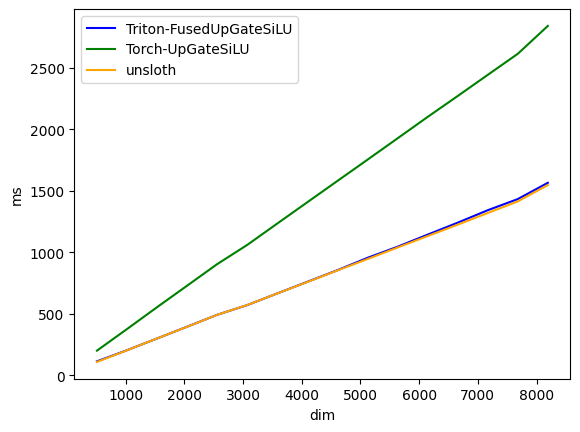

up gate silu backward:
       dim  Triton-FusedUpGateSiLU  Torch-UpGateSiLU      unsloth
0    512.0              114.764154        201.825589   110.137545
1   1024.0              205.374107        377.244532   204.629853
2   1536.0              300.625712        555.156171   300.936878
3   2048.0              396.385819        729.960918   395.744443
4   2560.0              493.156582        905.090213   493.123591
5   3072.0              572.192013       1061.242580   572.603524
6   3584.0              666.954637       1235.213161   666.498840
7   4096.0              761.382878       1408.275723   759.769082
8   4608.0              855.613947       1581.305623   853.585303
9   5120.0              955.990851       1753.918052   946.404576
10  5632.0             1046.332717       1927.388668  1039.892197
11  6144.0             1144.660115       2101.396322  1133.220196
12  6656.0             1241.818190       2271.324396  1225.693226
13  7168.0             1343.145609       2443.384171 

In [ ]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU', 'unsloth'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",'unsloth'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 32}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    up.requires_grad_(True)
    gate = torch.randn_like(up)
    gate.requires_grad_(True)
    dy = torch.ones_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'Triton-FusedUpGateSiLU':
        y = fused_up_gate_silu(up, gate)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[up, gate])
    if provider == 'Torch-UpGateSiLU':
        y = up_gate_silu(up, gate)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[up, gate])
    if provider == 'unsloth':
        y = fused_up_gate_silu_unsloth(up, gate)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[up, gate])

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# forward + backward

bs: 32, seq_len: 1024


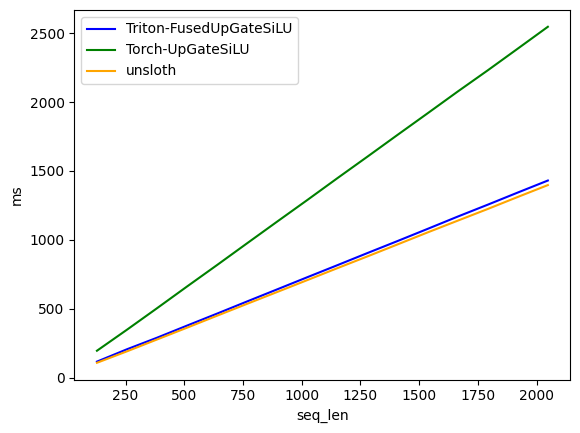

forward + backward:
    seq_len  Triton-FusedUpGateSiLU  Torch-UpGateSiLU      unsloth
0     128.0              116.312034        195.294008   107.865833
1     256.0              206.050307        348.098874   191.070989
2     384.0              289.880484        504.111528   277.046710
3     512.0              377.909541        661.999464   362.893552
4     640.0              465.009779        817.976534   449.810028
5     768.0              553.451538        975.995600   536.166549
6     896.0              641.072392       1133.300304   622.021377
7    1024.0              729.009867       1289.518476   708.114564
8    1152.0              816.298306       1447.942972   794.735491
9    1280.0              904.446781       1604.239702   880.138159
10   1408.0              991.450965       1762.030363   966.881931
11   1536.0             1079.732418       1918.559909  1053.977847
12   1664.0             1168.753028       2076.270103  1139.202237
13   1792.0             1255.268574       

In [11]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU', 'unsloth'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",'unsloth'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 18944, 'bs': 4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    up.requires_grad_(True)
    gate = torch.randn_like(up)
    gate.requires_grad_(True)
    dy = torch.ones_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def func(ops, gate, up, dy):
        y = ops(up, gate)
        y.backward(dy)

    if provider == 'Triton-FusedUpGateSiLU':
        ms = triton.testing.do_bench(lambda: func(fused_up_gate_silu, gate, up, dy), grad_to_none=[up, gate])
    if provider == 'Torch-UpGateSiLU':
        ms = triton.testing.do_bench(lambda: func(up_gate_silu, gate, up, dy), grad_to_none=[up, gate])
    if provider == 'unsloth':
        ms = triton.testing.do_bench(lambda: func(fused_up_gate_silu_unsloth, gate, up, dy), grad_to_none=[up, gate])

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


bs: 32, seq_len: 1024


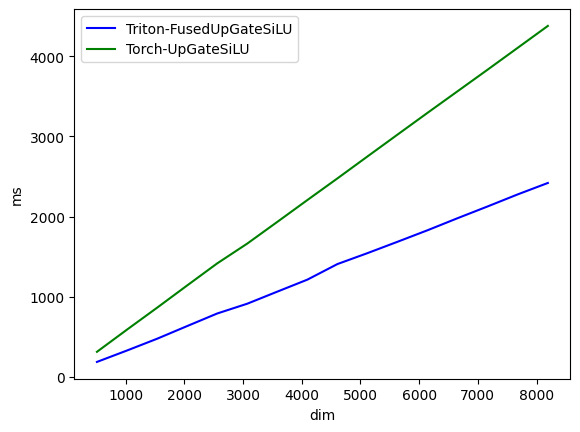

up gate silu forward + backward:
       dim  Triton-FusedUpGateSiLU  Torch-UpGateSiLU
0    512.0              187.339664        313.333631
1   1024.0              329.815477        590.434074
2   1536.0              476.323873        863.433540
3   2048.0              634.431541       1141.050220
4   2560.0              791.469097       1416.579008
5   3072.0              913.540542       1663.715363
6   3584.0             1064.322591       1934.445143
7   4096.0             1213.841081       2206.982851
8   4608.0             1408.272028       2477.096319
9   5120.0             1544.722319       2750.977278
10  5632.0             1686.546206       3023.798227
11  6144.0             1830.435634       3295.796871
12  6656.0             1981.032729       3565.246105
13  7168.0             2127.761841       3834.771395
14  7680.0             2277.846575       4107.024670
15  8192.0             2420.019865       4379.351139


In [62]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 32}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    up.requires_grad_(True)
    gate = torch.randn_like(up)
    gate.requires_grad_(True)
    dy = torch.ones_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def func(ops, gate, up, dy):
        y = ops(up, gate)
        y.backward(dy)

    if provider == 'Triton-FusedUpGateSiLU':
        ms = triton.testing.do_bench(lambda: func(fused_up_gate_silu, gate, up, dy), grad_to_none=[up, gate])
    if provider == 'Torch-UpGateSiLU':
        y = up_gate_silu(up, gate)
        ms = triton.testing.do_bench(lambda: func(up_gate_silu, gate, up, dy), grad_to_none=[up, gate])

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# v3
- 提供第三种接口，比如有同学的代码是这样的，MLP的up和gate是一个矩阵，计算效率高，但是后续需要去切，切出来的up和gate都不是连续的
- 如果用v1和v2的话，都需要将其转换为连续的，降低效率

In [2]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_size, up_hidden_size):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_size, up_hidden_size*2)
        self.down = torch.nn.Linear(up_hidden_size, hidden_size)
        self.act_fn = torch.nn.SiLU()
    
    def forward(self, hidden_states):
        out = self.fc(hidden_states)
        up, gate = out.chunk(2, -1)
        return self.down(self.act_fn(gate) * up)

In [ ]:
# 按行处理

@triton.jit
def _fused_silu_fwdv2(X, Y,
                    N, 
                    stride_m, stride_n,  #
                    BLOCK_SIZE_N: tl.constexpr, ORDER:tl.constexpr,
                    ):

    pid = tl.program_id(axis=0)
    x_offset = pid * stride_m
    y_offset = x_offset // 2
    X += x_offset
    Y += y_offset
    if ORDER == 'up-gate':
        up_offset = 0
        gate_offset = N
    else:
        up_offset = N
        gate_offset = 0

    cols = tl.arange(0, BLOCK_SIZE_N)
    for start_n in tl.range(0, N, BLOCK_SIZE_N):
        new_cols = cols + start_n
        mask = new_cols < N
        up = tl.load(X+new_cols+up_offset, mask=mask, other=0.)
        dtype = up.dtype
        up = up.to(tl.float32)
        gate = tl.load(X+new_cols+gate_offset, mask=mask, other=0.).to(tl.float32)
        act = gate * tl.sigmoid(gate)
        y = act * up
        tl.store(Y+new_cols, y.to(dtype), mask=mask)

@triton.jit
def _fused_silu_bwd_dupgatev2(X, 
                            DY, DX,
                            N,
                            stride_m, stride_n,
                            BLOCK_SIZE_N: tl.constexpr,ORDER:tl.constexpr
                            ):
    pid = tl.program_id(0)
    x_offset = pid * stride_m
    y_offset = x_offset // 2
    X += x_offset
    DX += x_offset
    DY += y_offset
    if ORDER == 'up-gate':
        up_offset = 0
        gate_offset = N
    else:
        up_offset = N
        gate_offset = 0

    cols = tl.arange(0, BLOCK_SIZE_N)
    for start_n in range(0, N, BLOCK_SIZE_N):
        new_cols = cols + start_n
        mask = new_cols < N
        
        dy = tl.load(DY+new_cols, mask=mask, other=0.)
        dtype = dy.dtype
        gate = tl.load(X+new_cols+gate_offset, mask=mask, other=0.).to(tl.float32)
        up = tl.load(X+new_cols+up_offset, mask=mask, other=0.).to(tl.float32)
        gate_sigmoid = tl.sigmoid(gate)
        act = gate_sigmoid * gate
        dup = act * dy
        dact = up * dy
        dgate = (gate_sigmoid + act * (1-gate_sigmoid)) * dact
        tl.store(DX+new_cols+up_offset, dup.to(dtype), mask=mask)
        tl.store(DX+new_cols+gate_offset, dgate.to(dtype), mask=mask)

class _FusedSiLUNoSplit(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, order='up-gate'):
        assert order in ['up-gate', 'gate-up'],"please indicate the order of tht out, up-gate or gate-up"
        input_shape = x.shape
        x = x.view(-1, input_shape[-1])
        # print(x.stride())
        M, N2 = x.shape
        N = N2 // 2
        y = torch.empty(*input_shape[:-1], N, device=x.device, dtype=x.dtype)
        BLOCK_SIZE_N = triton.next_power_of_2(N)
        BLOCK_SIZE_N = min(4096, BLOCK_SIZE_N)
        num_warps = 8
        num_stages = 4
        _fused_silu_fwdv2[(M,)](
            x, y, 
            N,  #
            *x.stride(),  #
            BLOCK_SIZE_N, order,
            num_warps=num_warps, num_stages=num_stages, 
        )
        ctx.infos = (M, N, BLOCK_SIZE_N, *x.stride(), order)
        ctx.input_shape = input_shape
        ctx.save_for_backward(x)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return y
    
    @staticmethod
    def backward(ctx, dy):
        # print(dy.stride())
        M, N, BLOCK_SIZE_N, stride_m, stride_n, order = ctx.infos
        # print(stride_m, stride_n)
        x, = ctx.saved_tensors

        dx = torch.empty(ctx.input_shape, device=dy.device, dtype=dy.dtype)
        # BLOCK_SIZE_N = min(8192, BLOCK_SIZE_N)
        _fused_silu_bwd_dupgatev2[(M,)](x,
                                   dy, dx,
                                   N,
                                   stride_m, stride_n,
                                   BLOCK_SIZE_N, order,
                                   num_warps=ctx.num_warps, num_stages=ctx.num_stages)

        return dx, None


fused_up_gate_silu_no_split = _FusedSiLUNoSplit.apply

def up_gate_silu_split(x):
    up,gate = x.chunk(2, -1)
    return up * torch.nn.functional.silu(gate)

# 直接替换即可
class NEWMLP(torch.nn.Module):
    def __init__(self, hidden_size, up_hidden_size):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_size, up_hidden_size*2)
        self.down = torch.nn.Linear(up_hidden_size, hidden_size)
        self.act_fn = torch.nn.SiLU()
    
    def forward(self, hidden_states):
        # 一行代码搞定
        return self.down(fused_up_gate_silu_no_split(self.fc(hidden_states, 'up-gate')))

In [4]:
dim = 4096
bs = 2
seq_len = 2048
dtype = torch.float32
x1 = torch.randn(bs, seq_len, dim*2).cuda().to(dtype)
x1.requires_grad_(True)
x2 = deepcopy(x1)
dy = torch.randn(bs, seq_len, dim).cuda().to(dtype)


In [5]:
if x1.grad is not None:
    x1.grad.zero_()
    x2.grad.zero_()
y1 = up_gate_silu_split(x1)
y1.backward(dy)

y2 = fused_up_gate_silu_no_split(x2)
y2.backward(dy)

atol = 1e-4
print(torch.allclose(y1, y2, atol=atol))
print(torch.allclose(x1.grad, x2.grad, atol=atol))

True
True


## forward

bs: 32, seq_len: 1024


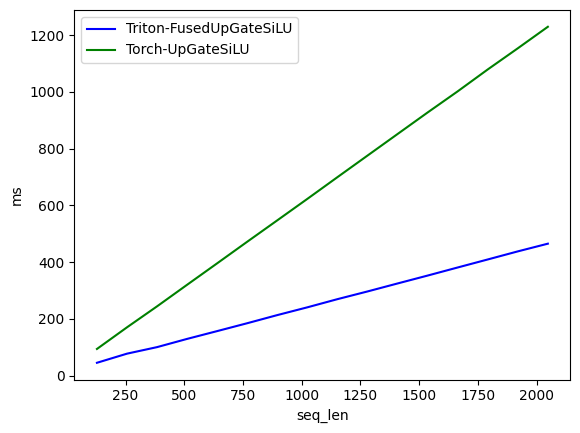

up gate silu forward:
    seq_len  Triton-FusedUpGateSiLU  Torch-UpGateSiLU
0     128.0               45.258358         93.969427
1     256.0               77.407934        170.266777
2     384.0              100.446731        244.193092
3     512.0              129.450336        320.233464
4     640.0              156.931922        395.861208
5     768.0              184.692502        471.936554
6     896.0              213.335186        547.326922
7    1024.0              240.711048        622.955680
8    1152.0              269.488126        699.433565
9    1280.0              296.626508        775.483370
10   1408.0              324.775696        851.466775
11   1536.0              352.623731        927.389920
12   1664.0              381.102473       1001.876354
13   1792.0              409.366459       1079.037309
14   1920.0              437.853992       1153.563023
15   2048.0              465.019733       1229.423761


In [17]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096*4, 'bs': 4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim*2).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'Triton-FusedUpGateSiLU':
        ms = triton.testing.do_bench(lambda: fused_up_gate_silu_no_split(x))
    if provider == 'Torch-UpGateSiLU':
        ms = triton.testing.do_bench(lambda: up_gate_silu_split(x))

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


## backward

bs: 32, seq_len: 1024


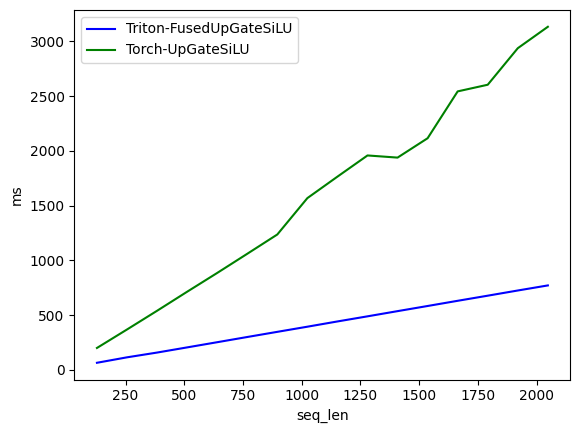

up gate silu forward:
    seq_len  Triton-FusedUpGateSiLU  Torch-UpGateSiLU
0     128.0               64.888321        200.152352
1     256.0              114.678860        368.754596
2     384.0              158.152059        539.566100
3     512.0              205.306500        713.350654
4     640.0              252.594531        884.784400
5     768.0              300.159156       1059.723377
6     896.0              347.270846       1235.915899
7    1024.0              394.201785       1567.914724
8    1152.0              442.121029       1763.851047
9    1280.0              488.823384       1957.287431
10   1408.0              536.248863       1937.655091
11   1536.0              583.243191       2114.478111
12   1664.0              630.665839       2542.034864
13   1792.0              677.315950       2602.772236
14   1920.0              724.667788       2936.245680
15   2048.0              770.981073       3131.736994


In [18]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096*4, 'bs': 4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim*2).to(device).to(dtype)
    x.requires_grad_(True)
    dy = torch.randn(bs, seq_len, dim).cuda().to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'Triton-FusedUpGateSiLU':
        y = fused_up_gate_silu_no_split(x)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[x])
    if provider == 'Torch-UpGateSiLU':
        y = up_gate_silu_split(x)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[x])

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


## forward + backward

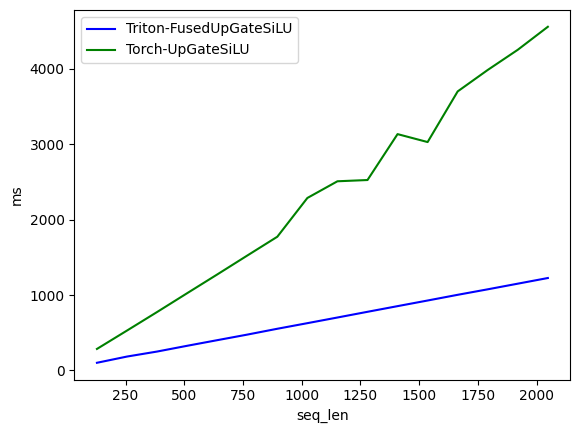

up gate silu forward:
    seq_len  Triton-FusedUpGateSiLU  Torch-UpGateSiLU
0     128.0              101.407997        285.060495
1     256.0              184.007511        528.984904
2     384.0              250.331640        774.577439
3     512.0              326.748133       1024.197817
4     640.0              401.128024       1272.540689
5     768.0              475.097507       1523.560524
6     896.0              552.634180       1773.248553
7    1024.0              626.848459       2287.426949
8    1152.0              701.888025       2508.886576
9    1280.0              777.593970       2525.539160
10   1408.0              852.678120       3134.435654
11   1536.0              927.383304       3029.113531
12   1664.0             1002.980947       3700.879335
13   1792.0             1075.845957       3985.519886
14   1920.0             1150.754809       4253.269672
15   2048.0             1225.723863       4558.155537


In [7]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096*4, 'bs': 4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim*2).to(device).to(dtype)
    x.requires_grad_(True)
    dy = torch.randn(bs, seq_len, dim).cuda().to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def fwd_bwd(func, x, dy):
        y = func(x)
        y.backward(dy,retain_graph=True)

    if provider == 'Triton-FusedUpGateSiLU':
        y = fused_up_gate_silu_no_split(x)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fused_up_gate_silu_no_split, x, dy), grad_to_none=[x])
    if provider == 'Torch-UpGateSiLU':
        ms = triton.testing.do_bench(lambda: fwd_bwd(up_gate_silu_split, x, dy), grad_to_none=[x])

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


## v3 pk v1 
- 可见连续的重要性

In [19]:
def fusefunc(x, func):
    up, gate = x.chunk(2, -1)
    up = up.contiguous()
    gate = gate.contiguous()
    y = func(up, gate)
    return y

- forward

bs: 32, seq_len: 1024


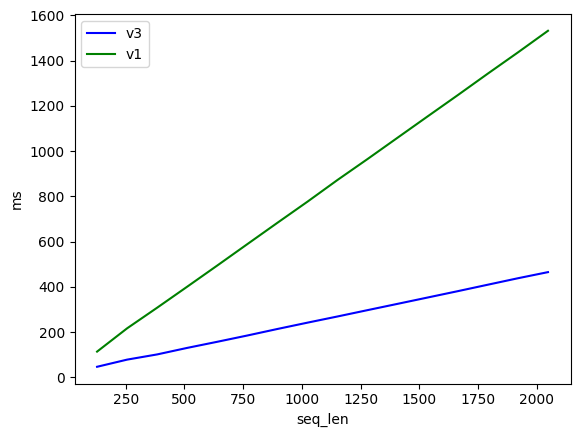

up gate silu forward:
    seq_len          v3           v1
0     128.0   46.457443   113.501757
1     256.0   78.114271   216.532037
2     384.0  101.115033   307.746559
3     512.0  129.971564   400.637805
4     640.0  156.992942   494.214118
5     768.0  184.730634   588.744342
6     896.0  213.561416   682.988942
7    1024.0  241.535276   776.359439
8    1152.0  268.862486   872.438669
9    1280.0  296.908796   964.990914
10   1408.0  324.747026  1059.353828
11   1536.0  352.708071  1153.572917
12   1664.0  380.682707  1247.307181
13   1792.0  409.288079  1342.447758
14   1920.0  437.789828  1436.005473
15   2048.0  464.848369  1531.654596


In [20]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['v3', 'v1'],  # possible values for `line_arg``
        line_names=[
            "v3",
            "v1",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096*4, 'bs': 4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim*2).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'v3':
        ms = triton.testing.do_bench(lambda: fused_up_gate_silu_no_split(x))
    if provider == 'v1':
        ms = triton.testing.do_bench(lambda: fusefunc(x, fused_up_gate_silu))

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


- backward

bs: 32, seq_len: 1024


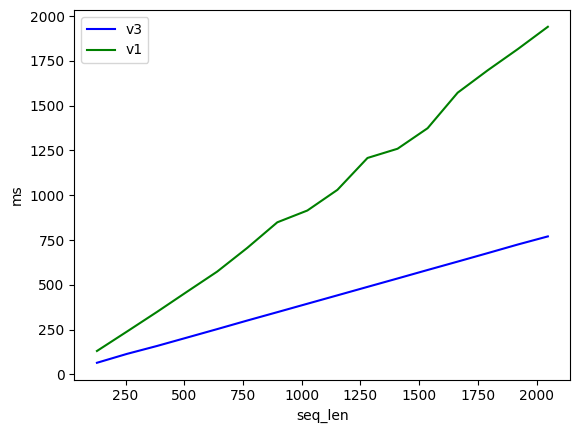

up gate silu forward:
    seq_len          v3           v1
0     128.0   64.837016   130.690977
1     256.0  114.581622   239.338592
2     384.0  158.776909   349.045277
3     512.0  205.735952   461.985946
4     640.0  252.855480   573.950410
5     768.0  300.716221   706.256330
6     896.0  347.425520   849.096656
7    1024.0  394.477606   914.990723
8    1152.0  441.438824  1030.401587
9    1280.0  488.563538  1208.309293
10   1408.0  535.532176  1259.826303
11   1536.0  582.916379  1374.470353
12   1664.0  629.796267  1572.819948
13   1792.0  677.138567  1697.862029
14   1920.0  725.114584  1816.100478
15   2048.0  770.393729  1940.711021


In [21]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['v3', 'v1'],  # possible values for `line_arg``
        line_names=[
            "v3",
            "v1",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096*4, 'bs': 4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim*2).to(device).to(dtype)
    x.requires_grad_(True)
    dy = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'v3':
        y = fused_up_gate_silu_no_split(x)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[x])
    if provider == 'v1':
        y = fusefunc(x, fused_up_gate_silu)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[x])

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
